In [1]:
import tensorflow.keras as keras
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from tensorflow.keras.applications.resnet50 import ResNet50
import xgboost as xgb

In [2]:
def grab_image(img_path):
    img = image.load_img(img_path, target_size=(208, 176))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [3]:
negative_images = np.concatenate( [grab_image('AlzheimersDataset/Negative/neg(%d).jpg'%(i)) for i in range(1, 3201)])
positive_images = np.concatenate( [grab_image('AlzheimersDataset/Positive/pos(%d).jpg'%(i)) for i in range(1, 3201)])

In [4]:
negative_labels = np.zeros(3200, dtype=int)
positive_labels = np.ones(3200, dtype=int)

In [5]:
X = np.concatenate([negative_images, positive_images])
Y = np.concatenate([negative_labels, positive_labels])

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [7]:
#ResNet50
resnet_model = ResNet50(weights = 'imagenet',  include_top = False, input_shape = (208, 176, 3)) 

94765736/94765736 [==============================] - 6s 0us/step


In [8]:
# make all layers non-trainable
for layer in resnet_model.layers : 
    layer.trainable = False

In [9]:
%%time

feature_extractor = resnet_model.predict(X_train)

160/160 [==============================] - 326s 2s/step
Wall time: 5min 29s


In [10]:
# reshape
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_train_features = features

In [11]:
# do same operation on test dataset
feature_extractor_test = resnet_model.predict(X_test)
features_test = feature_extractor_test.reshape(feature_extractor_test.shape[0], -1)
X_test_features = features_test

40/40 [==============================] - 78s 2s/step


In [12]:
%%time

model = xgb.XGBClassifier()
history = model.fit(X_train_features, Y_train, verbose=1)

Wall time: 12min 43s


In [13]:
prediction = model.predict(X_test_features)

In [14]:
from sklearn import metrics
print('Accuracy : ', metrics.accuracy_score(Y_test, prediction))

Accuracy :  0.95


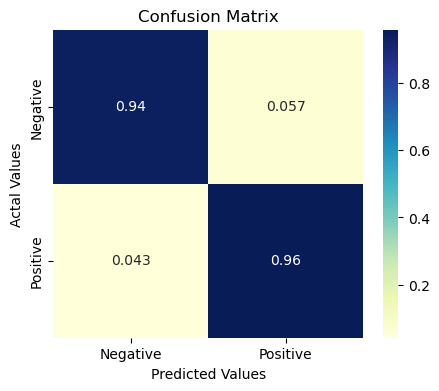

In [15]:
cm = confusion_matrix(Y_test, prediction, normalize = "true")
cm_df = pd.DataFrame(cm,
index = ['Negative','Positive'],
columns = ['Negative','Positive'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.savefig('myCNN2')

In [16]:
FP = 0.057
FN = 0.043
TP = 0.96
TN = 0.94

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Recall: ")
print(TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP)
print("Specificity: ")
print(TNR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Presicion: ")
print(TNR)

# Negative predictive value
NPV = TN/(TN+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("Fall Out: ")
print(FPR)

# False negative rate
FNR = FN/(TP+FN)

# False discovery rate
FDR = FP/(TP+FP)

Total = FP+FN+TP+TN

# Overall accuracy
ACC = (TP+TN)/Total
print("Accuracy: ")
print(ACC)

# Random accuracy
R_ACC = ((TN+FP)*(TN+FN)+(FN+TP)*(FP+TP))/(Total*Total)

# Kappa
KAPPA = (ACC-R_ACC)/(1-R_ACC)
print("Kappa: ")
print(KAPPA)

F1 = 2 * (TNR * TPR) / (TNR + TPR)
print("F1:")
print(F1)

Recall: 
0.9571286141575275
Specificity: 
0.9428284854563691
Presicion: 
0.9428284854563691
Fall Out: 
0.0571715145436309
Accuracy: 
0.95
Kappa: 
0.8999948997398867
F1:
0.949924734465299
